# Classification Between SHH Infant and Child

## Required Imports 

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

## Data Preprocessing/Loading

In [2]:
# load data
file_path = "/Users/samwwong/Desktop/Michael Zhang/shh_age_group.xlsx"
df = pd.read_excel(file_path)
df.head()

,age_group,molecular,molec_id,sex,dx_date,age,alive,os,pfs,seg_id,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,young,shh,SE_PF-MB_F_0022,F,2011-06-28 00:00:00,0.000000,alive,104.0,104.0,SE_PF-MB_F_0022A,...,5.609351,0.000816,2599.018591,0.389658,0.648485,1586.090798,0.000596,7.635250,0.172423,7765.493913
1,young,shh,GO_PF-MB_F_0026,F,2018-11-18 00:00:00,5.390000,Alive,13.0,NaN,GO_PF-MB_F_0026_,...,0.763452,0.001410,5792.493691,0.514705,0.745441,2462.831077,0.000914,7.924751,0.304623,1430.199779
2,young,shh,CG_PF-MB_U_0043,M,"8/25/14, 3:58 PM",10.980822,NaN,NaN,NaN,CG_PF-MB_U_0043_,...,0.136851,0.000540,5817.397225,0.360389,0.621955,2009.635379,0.000311,8.082616,0.278700,217.263798
3,young,shh,ST_PF-MB_M_0060,M,2004-08-07 00:00:00,11.000000,NaN,10.0,6.0,ST_PF-MB_M_0060_,...,2.385623,0.001147,5043.674541,0.348368,0.611608,1147.810569,0.000710,8.017516,0.179550,2365.949413
4,young,shh,DU_PF-MB_U_0012,M,2009-07-16 00:00:00,12.000000,Alive,26.4,NaN,DU_PF-MB_U_0012_,...,8.584564,0.001695,4522.271872,0.386750,0.645659,829.824976,0.001084,7.558939,0.244398,3527.049493


In [3]:
# obtain list of features selected from LASSO
reduced_feats_path = "/Users/samwwong/Desktop/Michael Zhang/reduced_molec.xlsx"
reduced_features = pd.read_excel(reduced_feats_path)
reduced_features_list = reduced_features.loc[reduced_features['shh_age_group'].isnull() == False, 
                                             ['shh_age_group']].values.tolist()
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]
features_after_lasso = df[reduced_features_list]
print(reduced_features_list)

['t1_log-sigma-3-mm-3D_glrlm_RunLengthNonUniformity', 't1_wavelet-HHL_glszm_GrayLevelNonUniformityNormalized', 't1_wavelet-HHL_glszm_ZoneEntropy', 't1_wavelet-LLH_firstorder_Median', 't2_log-sigma-5-mm-3D_firstorder_Median', 't2_log-sigma-5-mm-3D_firstorder_90Percentile', 't1_log-sigma-1-mm-3D_glcm_ClusterShade', 't1_wavelet-HHH_glszm_SizeZoneNonUniformityNormalized', 't1_wavelet-LHL_firstorder_Skewness', 't2_wavelet-LLL_glcm_Idmn', 't2_wavelet-LLL_glrlm_LongRunLowGrayLevelEmphasis', 't1_wavelet-LLH_firstorder_Skewness', 't1_wavelet-HHL_glcm_MCC', 't2_wavelet-LHH_glszm_SizeZoneNonUniformityNormalized', 't2_wavelet-LLH_glrlm_GrayLevelNonUniformity']


In [4]:
# Binarizing target
target = df["age_group"]

# Marking 0 as infant and 1 child
mapping_dict = {0: 'young', 1: 'old'}
target = target.map(dict(young = 0, old = 1))
print(target.value_counts())

0    50
1    33
Name: age_group, dtype: int64


In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)
print("TRAIN")
print(y_train.value_counts())

print("TEST")
print(y_test.value_counts())

TRAIN
0    35
1    27
Name: age_group, dtype: int64
TEST
0    15
1     6
Name: age_group, dtype: int64


### Resampling to Correct for Imbalance

In [6]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['age_group'] == 0]
X_1 = X[X['age_group'] == 1]

In [7]:
upsampled_1 = resample(X_1, replace = True, n_samples = len(X_0), random_state = 42)
upsampled = pd.concat([upsampled_1, X_0])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [8]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]
print(y_train.value_counts())

1    35
0    35
Name: age_group, dtype: int64


### Standardizing Features

In [9]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [10]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [11]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

## Modeling

### User Defined Functions for Metrics

In [12]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.4f} - {:0.4}]".format(name, 
    confidence_lower, confidence_upper))

In [13]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TN / (TN + FP)

In [14]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [15]:
def negative_pv_score(y_true, y_pred):
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN)        

In [16]:
def print_metrics(y_test, y_pred):
    print("Sens Score: " + str.format('{0:.4f}', (recall_score(y_test, y_pred))))
    print("Spec Score: " + str.format('{0:.4f}', (specificity_score(y_test.to_numpy(), y_pred))))
    print("PPV Score: " + str.format('{0:.4f}', (positive_pv_score(y_test.to_numpy(), y_pred))))
    print("NPV Score: " + str.format('{0:.4f}', (negative_pv_score(y_test.to_numpy(), y_pred))))
    print("Acc Score: " + str.format('{0:.4f}', (accuracy_score(y_test, y_pred))))
    print("F1 Score: " + str.format('{0:.4f}', (f1_score(y_test, y_pred))))

In [17]:
def plot_roc_curve(model_name):
    sns.set()
    plt.figure(figsize=(7, 7))

    ns_preds = [0 for _ in range(len(y_test))]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name)
    plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

    plt.legend(loc='lower right')
    plt.title(f'{model_name}: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    short_auc = round(auc,4)
    plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
    plt.show()

In [18]:
def create_confusion_matrix(model_name, model, X, y):
    matrix = plot_confusion_matrix(model, X, y,
                               cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show(matrix)
    plt.show()

### User Defined Functions for Modeling 

In [19]:
def grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

### SVM

#### Grid Search for Hyperparameters

In [20]:
svm_model = svm.SVC()
svm_grid_params = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

grid_search(svm_model, svm_grid_params, X_train, y_train)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


#### Model Performance

In [21]:
svm_model = svm.SVC(C = 1, gamma = 0.1, kernel = 'rbf', probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [22]:
print_metrics(y_test, y_pred)

Sens Score: 0.3333
Spec Score: 1.0000
PPV Score: 1.0000
NPV Score: 0.7895
Acc Score: 0.8095
F1 Score: 0.5000


In [23]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.7667


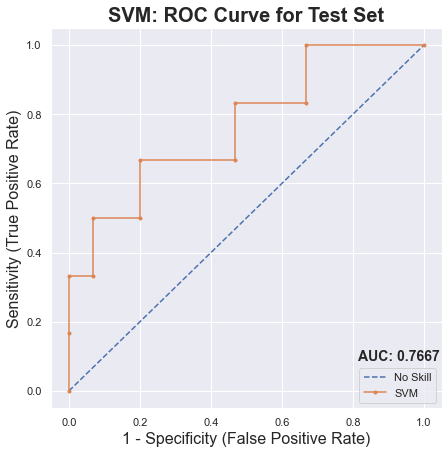

In [24]:
plot_roc_curve('SVM')

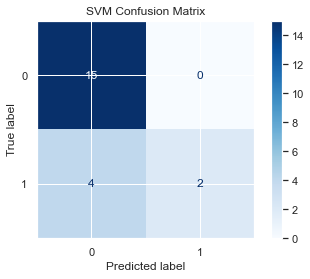

In [25]:
create_confusion_matrix('SVM', svm_model, X_test, y_test)

### Logistic Regression

#### Grid Search for Hyperparameters

In [26]:
lr_model = LogisticRegression()
lr_grid_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

grid_search(lr_model, lr_grid_params, X_train, y_train)

{'C': 0.001, 'penalty': 'l2'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.88571429        nan 0.88571429        nan 0.91428571
        nan 0.88571429        nan 0.91428571        nan 0.88571429
        nan 0.91428571        nan 0.88571429        nan 0.91428571
        nan 0.88571429]
  warnings.warn(


#### Model Performance

In [27]:
lr_model = LogisticRegression(penalty = 'l2', C = 0.001)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [28]:
print_metrics(y_test, y_pred)

Sens Score: 0.5000
Spec Score: 0.9333
PPV Score: 0.7500
NPV Score: 0.8235
Acc Score: 0.8095
F1 Score: 0.6000


In [29]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.9000


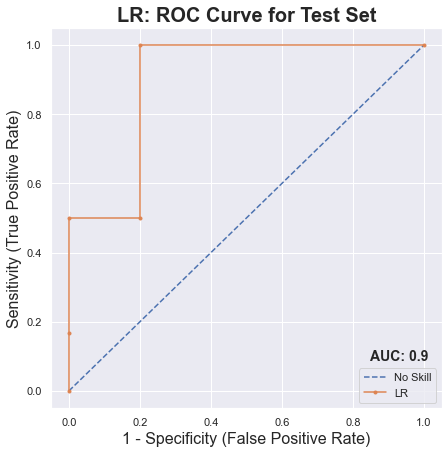

In [30]:
plot_roc_curve('LR')

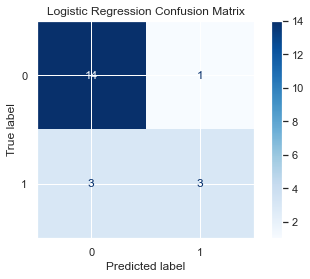

In [31]:
create_confusion_matrix('Logistic Regression', lr_model, X_test, y_test)

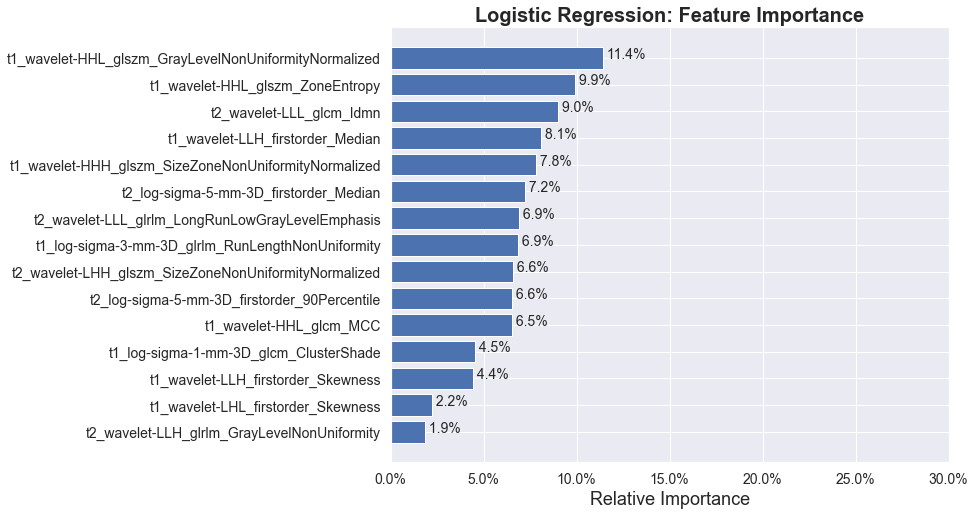

In [32]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.30)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14)

plt.xlabel('Relative Importance',fontsize=18)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(fontsize=14)

plt.show()

Feature: 0, Score: -0.01875
Feature: 1, Score: -0.02209
Feature: 2, Score: -0.04428
Feature: 3, Score: -0.04524
Feature: 4, Score: -0.06508
Feature: 5, Score: -0.06553
Feature: 6, Score: 0.06603
Feature: 7, Score: -0.06873
Feature: 8, Score: -0.06923
Feature: 9, Score: -0.07226
Feature: 10, Score: 0.07845
Feature: 11, Score: 0.08080
Feature: 12, Score: 0.09003
Feature: 13, Score: -0.09937
Feature: 14, Score: 0.11411


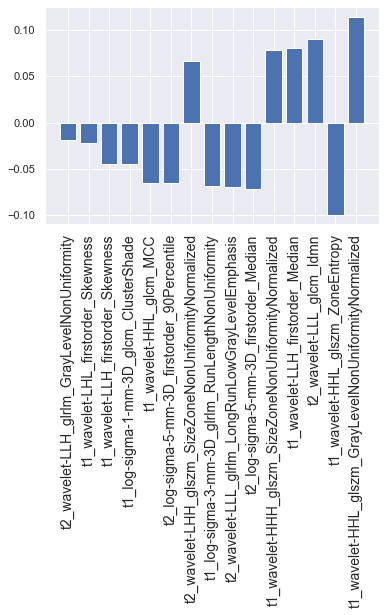

In [33]:
feature_names = X_test.columns.to_list()

importances_2 = lr_model.coef_[0]
importances_2 = (importances_2) / np.sum(np.abs(importances_2))

# summarize feature importance
for i,v in enumerate(importances_2[indices]):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importances_2))], importances_2[indices])
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14, rotation = 90)


plt.show()

### KNN

#### Grid Search for Hyperparameters

In [34]:
knn_model = KNeighborsClassifier()
knn_grid_params = {'n_neighbors': [3, 5, 7, 9]
}

grid_search(knn_model, knn_grid_params, X_train, y_train)

{'n_neighbors': 5}


#### Model Performance

In [35]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [36]:
print_metrics(y_test, y_pred)

Sens Score: 0.5000
Spec Score: 0.9333
PPV Score: 0.7500
NPV Score: 0.8235
Acc Score: 0.8095
F1 Score: 0.6000


In [37]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.8889


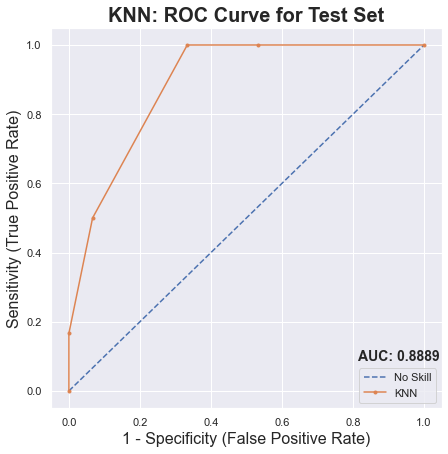

In [38]:
plot_roc_curve('KNN')

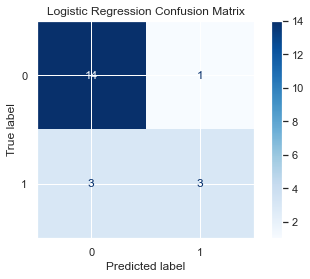

In [39]:
create_confusion_matrix('Logistic Regression', knn_model, X_test, y_test)

### Random Forest

#### Grid Search for Hyperparameters

In [40]:
rf_model = RandomForestClassifier(random_state = 42)
rf_grid_params = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

grid_search(rf_model, rf_grid_params, X_train, y_train)

{'max_depth': 4, 'n_estimators': 50}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.81428571 0.87142857 0.84285714 0.84285714        nan
 0.88571429 0.85714286 0.88571429 0.88571429        nan 0.91428571
 0.9        0.9        0.9               nan 0.92857143 0.88571429
 0.88571429 0.9       ]
  warnings.warn(


#### Model Performance

In [41]:
rf_model = RandomForestClassifier(max_depth = 4, n_estimators = 50, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [42]:
print_metrics(y_test, y_pred)

Sens Score: 0.8333
Spec Score: 0.9333
PPV Score: 0.8333
NPV Score: 0.9333
Acc Score: 0.9048
F1 Score: 0.8333


In [43]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.8889


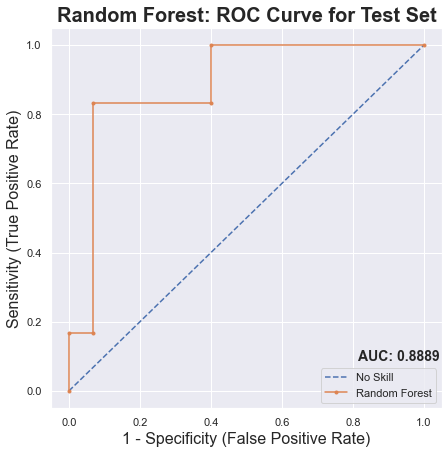

In [44]:
plot_roc_curve('Random Forest')

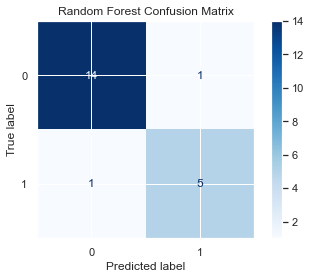

In [45]:
create_confusion_matrix('Random Forest', rf_model, X_test, y_test)

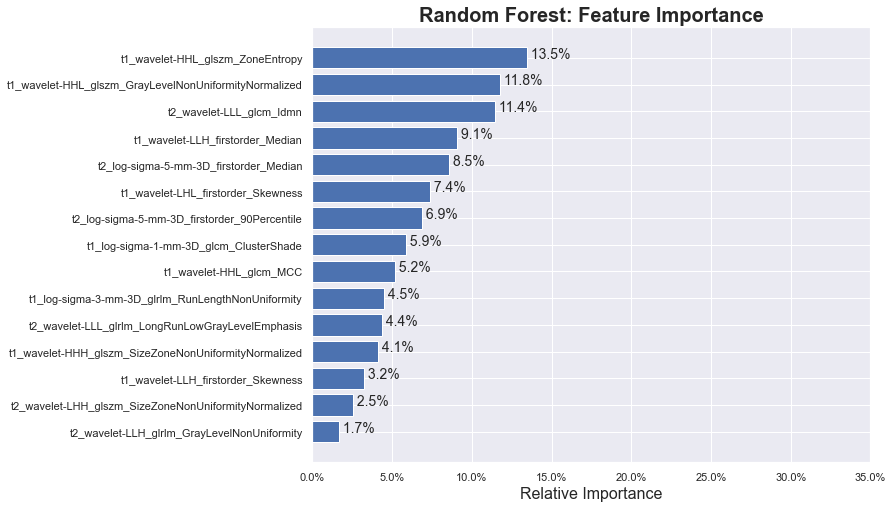

In [46]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Random Forest: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.35)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

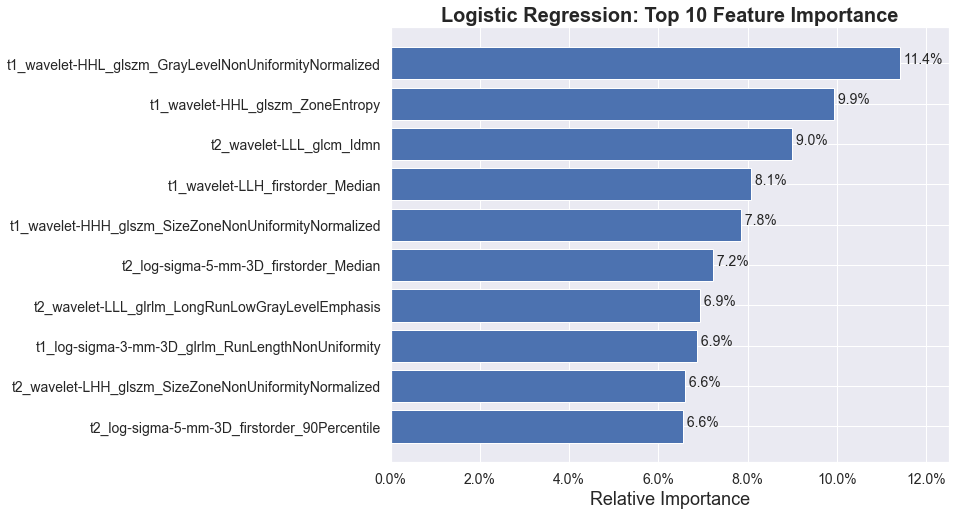

In [47]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Top 10 Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='b', align='center')
#plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.125)
for index, value in enumerate(importances[indices[-10:]]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)

plt.yticks(range(len(indices[-10:])), [feature_names[i] for i in indices[-10:]], fontsize=14)

plt.xlabel('Relative Importance',fontsize=18)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(fontsize=14)

plt.show()

### XGBoost

#### Grid Search for Hyperparameters

In [48]:
xgb_model = XGBClassifier(random_state = 42)
xgb_grid_params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

grid_search(xgb_model, xgb_grid_params, X_train, y_train)

{'learning_rate': 0.5, 'max_depth': 3}


#### Model Performance

In [49]:
xgb_model = XGBClassifier(learning_rate = 0.5, max_depth = 3, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [50]:
print_metrics(y_test, y_pred)

Sens Score: 0.1667
Spec Score: 0.8667
PPV Score: 0.3333
NPV Score: 0.7222
Acc Score: 0.6667
F1 Score: 0.2222


In [51]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.6778


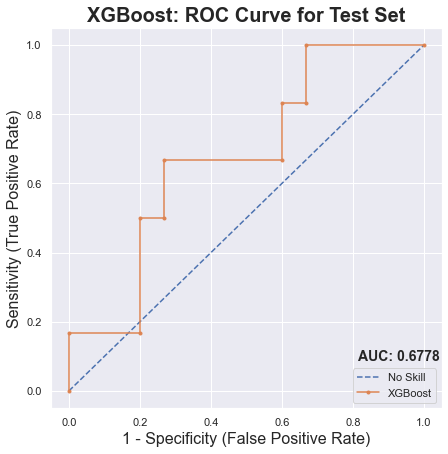

In [52]:
plot_roc_curve('XGBoost')

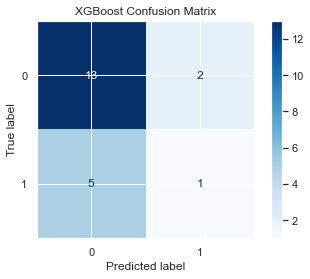

In [53]:
create_confusion_matrix('XGBoost', xgb_model, X_test, y_test)

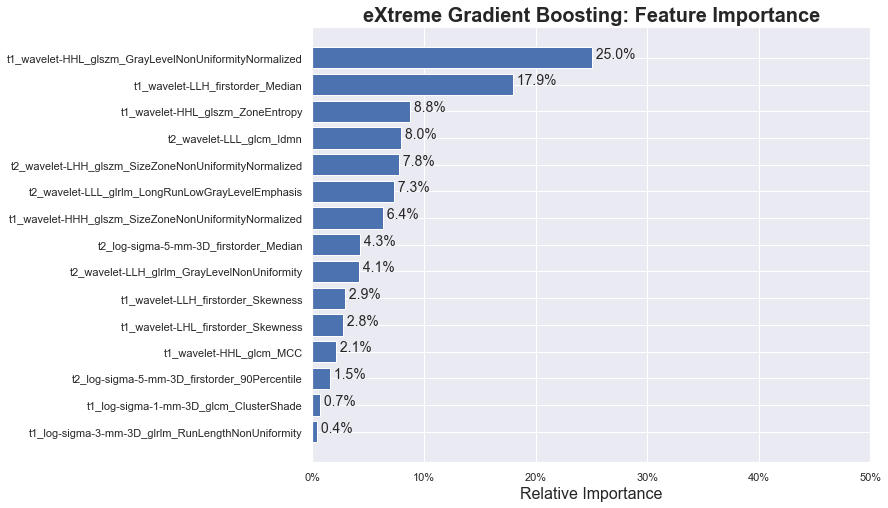

In [54]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('eXtreme Gradient Boosting: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.5)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### Neural Net

#### Grid Search for Hyperparameters

In [55]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
nn_grid_params = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search(nn_model, nn_grid_params, X_train, y_train)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


#### Model Performance

In [56]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [57]:
print_metrics(y_test, y_pred)

Sens Score: 0.5000
Spec Score: 1.0000
PPV Score: 1.0000
NPV Score: 0.8333
Acc Score: 0.8571
F1 Score: 0.6667


In [58]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.8889


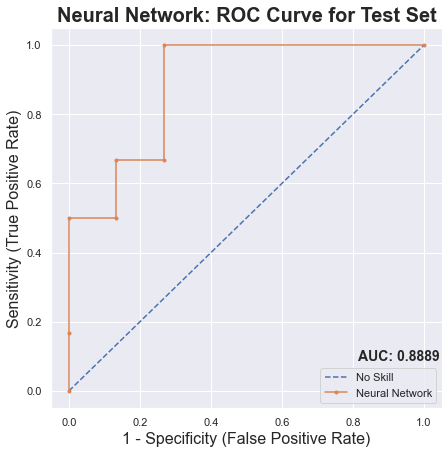

In [59]:
plot_roc_curve('Neural Network')

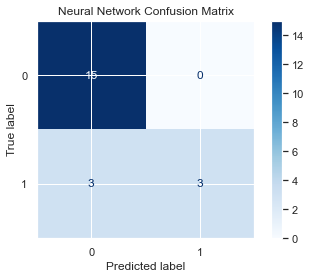

In [60]:
create_confusion_matrix('Neural Network', nn_model, X_test, y_test)

#### Producing Output

In [61]:
metadata_df = df['age_group']
target_for_table = df['age_group']

metadata_df

features_for_table = df.drop(['molec_id','dx_date','alive','os','pfs','seg_id','molecular','age_group'], axis = 1)
target_for_table = target_for_table.map(dict(young = 0, old = 1))

target_for_table

X_train_for_table, X_test_for_table, _, _ = train_test_split(features_for_table, target_for_table, 
                                                    test_size = 0.25, random_state = 42)

X_train_for_table['Set'] = 'training'
X_test_for_table['Set'] = 'test'

X_for_table = pd.concat([X_train_for_table, X_test_for_table])
X_for_table = pd.merge(metadata_df, X_for_table, left_index = True, right_index = True)

final_df = X_for_table[['age_group', 'Set']]
features_for_table = df.drop(['molec_id','dx_date','alive','os','pfs','seg_id','molecular','age_group'], axis = 1)
target_for_table = X_for_table['age_group']
target_for_table = target_for_table.map(dict(young = 0, old = 1))

#features_for_table

X_table_reduced = features_for_table[reduced_features_list]

#sex_binarized = X_table_reduced['sex'].map(dict(M = 1, F = 0)).to_numpy()
#X_table_reduced['sex'] = sex_binarized

X_table_reduced

names = X_table_reduced.columns
X_table_for_probs = scaler.transform(X_table_reduced)
X_table_for_probs = pd.DataFrame(X_table_for_probs, columns = names)

y_probs = lr_model.predict_proba(X_table_for_probs)

rf_table = pd.DataFrame(y_probs, columns = ['Young Prob','Old Prob'])

final_df['Young Prob'] = rf_table['Young Prob']
final_df['Old Prob'] = rf_table['Old Prob']


final_df['molec_id'] = df['molec_id']
final_df = final_df.round(4)

final_df
final_df.to_csv('lr_shh_age_group_classification_results.csv')

<ipython-input-61-96b12fc44c2c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_for_table['Set'] = 'training'
<ipython-input-61-96b12fc44c2c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_for_table['Set'] = 'test'
<ipython-input-61-96b12fc44c2c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid